In [1]:
from __future__ import division
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.stats as stats

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score

from composition.analysis.load_sim import load_sim
from composition.analysis.preprocessing import get_train_test_sets, LabelEncoder
from composition.analysis.features import get_training_features
from composition.analysis.pipelines import get_pipeline
import composition.analysis.data_functions as data_functions
from composition.support_functions.checkdir import checkdir

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_palette('muted')
sns.set_color_codes()

In [3]:
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'max_charge_frac', 'reco_containment',
                     'min_energy', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list = get_training_features()
X_train, X_test, y_train, y_test, le = get_train_test_sets(df, feature_list)

print('events = ' + str(y_train.shape[0]))

/home/jbourbeau/composition/analysis/load_sim.py:65: RuntimeWarning: divide by zero encountered in log10
  df['reco_log_energy'] = np.nan_to_num(np.log10(df['reco_energy']))
/home/jbourbeau/composition/analysis/load_sim.py:66: RuntimeWarning: invalid value encountered in log10
  df['InIce_log_charge'] = np.nan_to_num(np.log10(df['InIce_charge']))


events = 72644


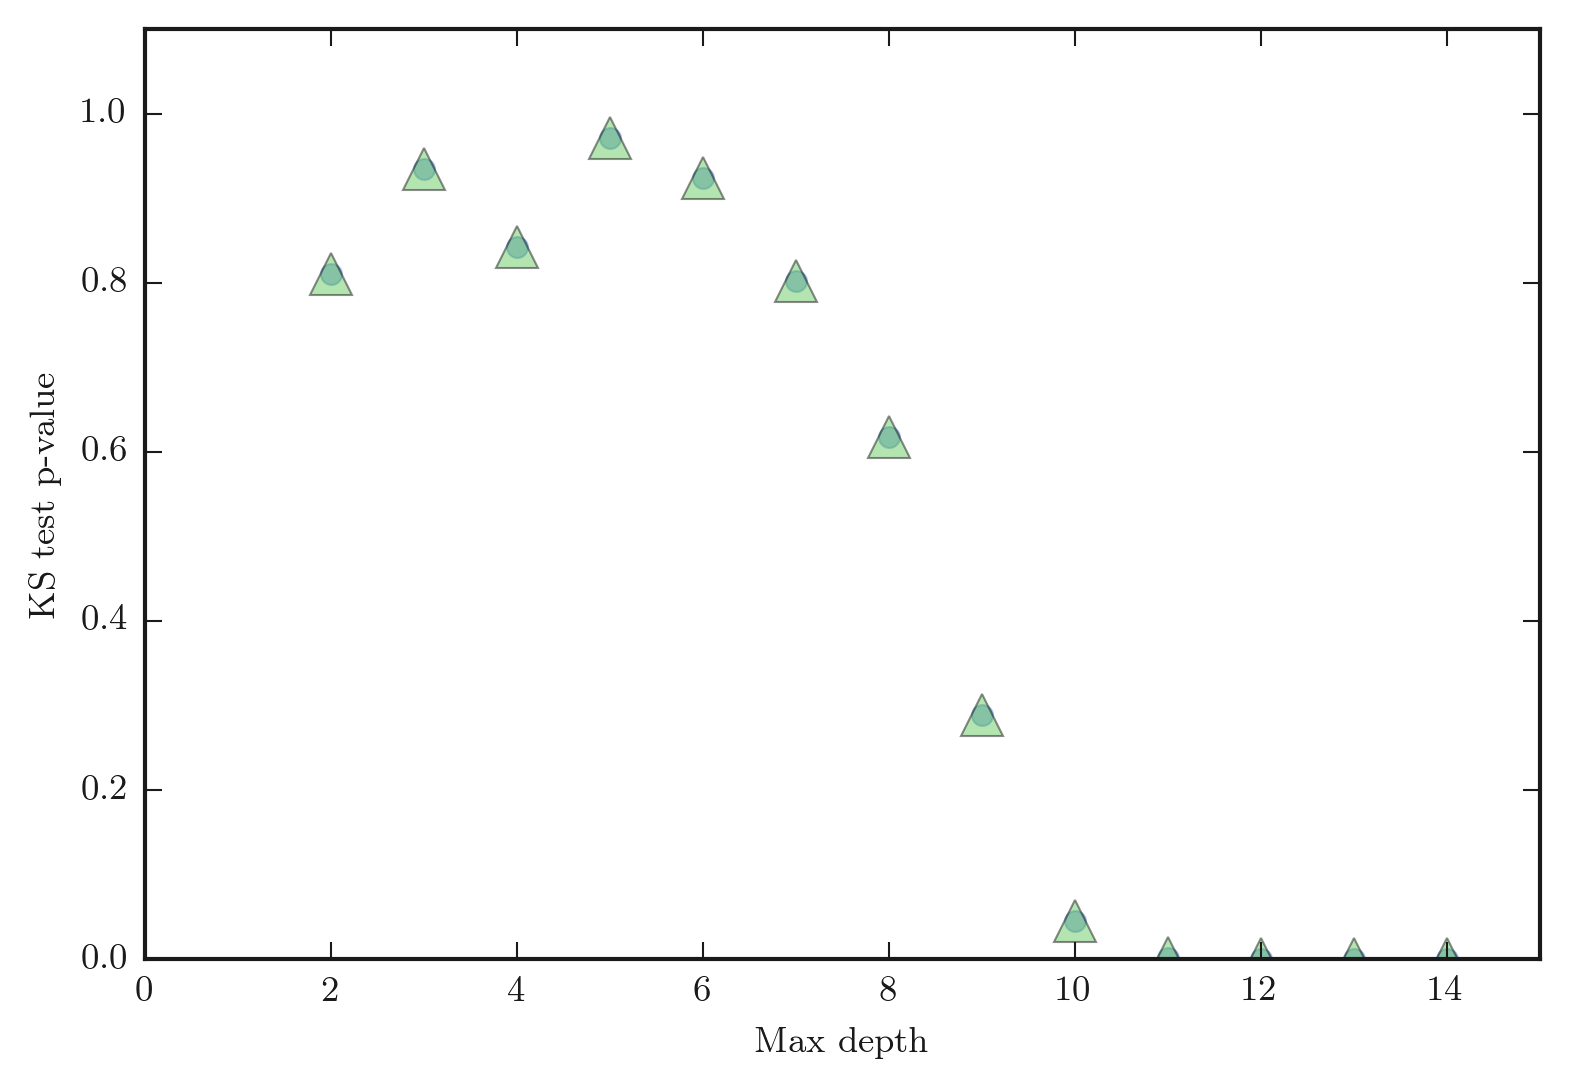

In [5]:
max_depth_list = np.arange(2, 15)
ks_proton = []
pval_proton = []
ks_iron = []
pval_iron = []

for depth in max_depth_list:
    pipeline = get_pipeline('RF')
    pipeline.named_steps['classifier'].set_params(max_depth=depth)
    pipeline.fit(X_train, y_train)
    test_probs = pipeline.predict_proba(X_test)
    train_probs = pipeline.predict_proba(X_train)
    k_proton, p_proton = stats.ks_2samp(test_probs[:,0], train_probs[:,0])
    ks_proton.append(k_proton)
    pval_proton.append(p_proton)
    k_iron, p_iron = stats.ks_2samp(test_probs[:,1], train_probs[:,1])
    ks_iron.append(k_iron)
    pval_iron.append(p_iron)

fig, ax = plt.subplots()
ax.plot(max_depth_list, pval_proton, markersize=10, alpha=0.5)
ax.plot(max_depth_list, pval_iron, marker='^', markersize=10, alpha=0.5)
plt.xlim([0,len(max_depth_list)+2])
plt.ylim([0,1.1])
# plt.show()
    
# plot_decision_regions(X_test_std, y_test, clf, scatter_fraction=None, ax=ax)
ax.set_xlabel('Max depth')
ax.set_ylabel('KS test p-value')
# ax.set_title('Max depth = {}'.format(depth))
# ax.legend()
# plt.tight_layout()
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-decision-regions.png')